In [ ]:
## Applying XGBoost for Supermarket Sales Prediction: A Machine Learning Approach.ipynb

#The main goal of this exercise is to demonstrate, in an educational manner, how to perform a predictive time series analysis using open data on supermarket
#sales in USA. To achieve this, we will conduct an exploratory data analysis, define and validate the predictive model,
#and finally generate predictions along with their corresponding graphs and visualizations.

In [ ]:
#STEPS:
  # 1. Data preparation
  # 2. Exploratory Data Analysis (EDA)
  # 3. Training model
  # 4. Model Validation
  # 5. Predictions based on ML



   Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010    1643690.90             0     5.727778       2.572   
1      1  12-02-2010    1641957.44             1     3.616667       2.548   
2      1  19-02-2010    1611968.17             0     4.405556       2.514   
3      1  26-02-2010    1409727.59             0     8.127778       2.561   
4      1  05-03-2010    1554806.68             0     8.055556       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106  
      Store       Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
189       2 2010-12-24    3436007.68             0     9.983333       2.886   
241       2 2011-12-23    3224369.80             0     8.144444       3.112   
471       4 2010-11-26    2789469.45             1     8.933333       2.752   
474       4 2010-12-17    2740057.14     

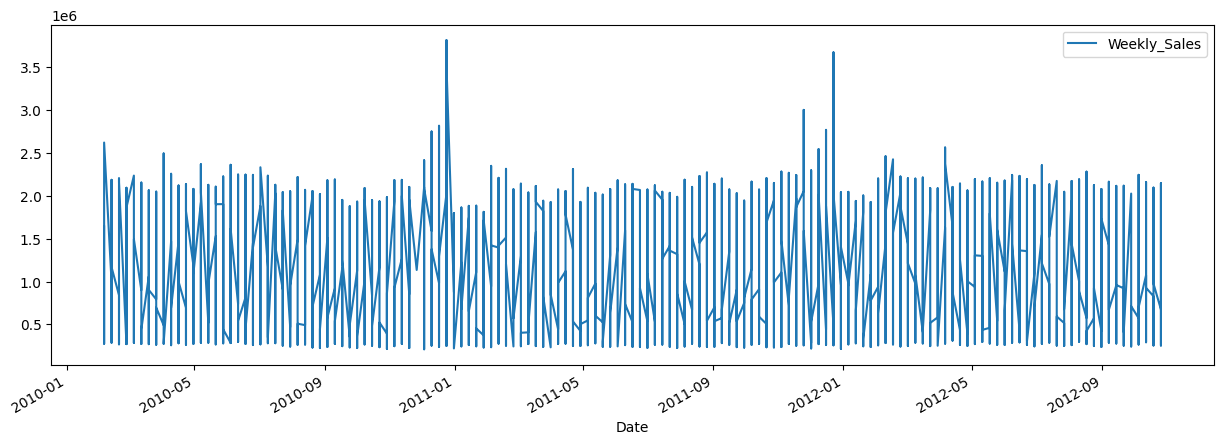

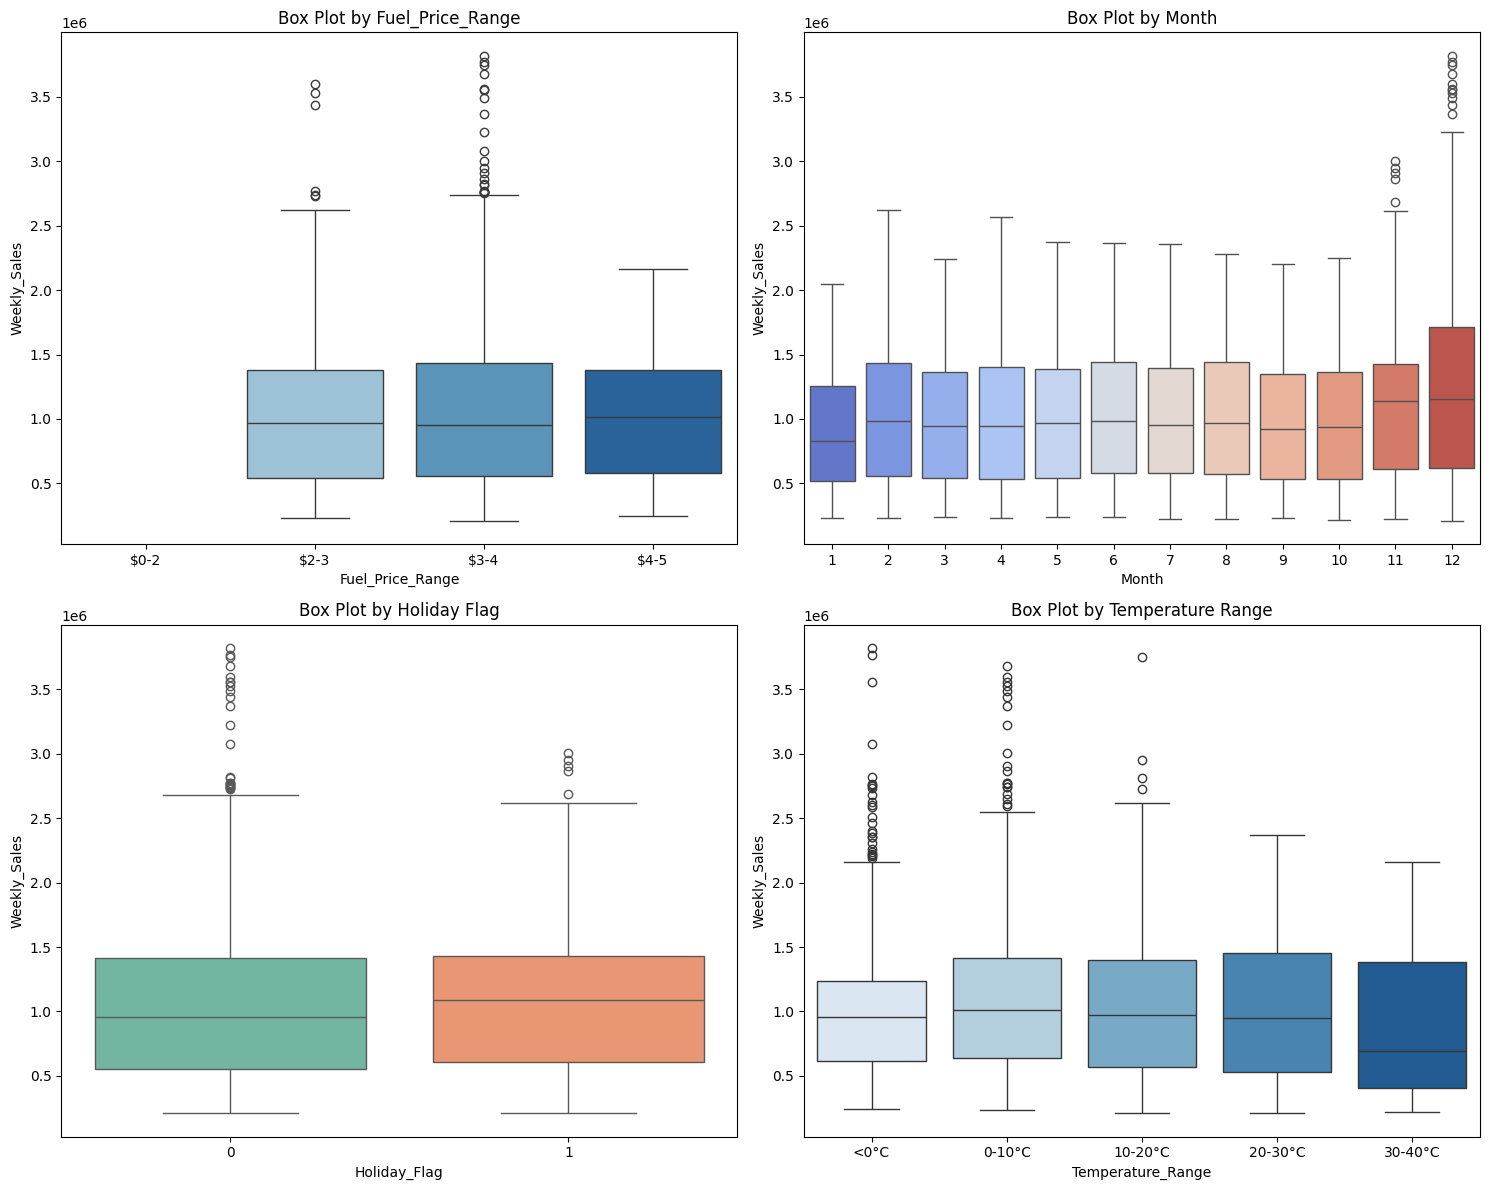

<Axes: xlabel='Date'>

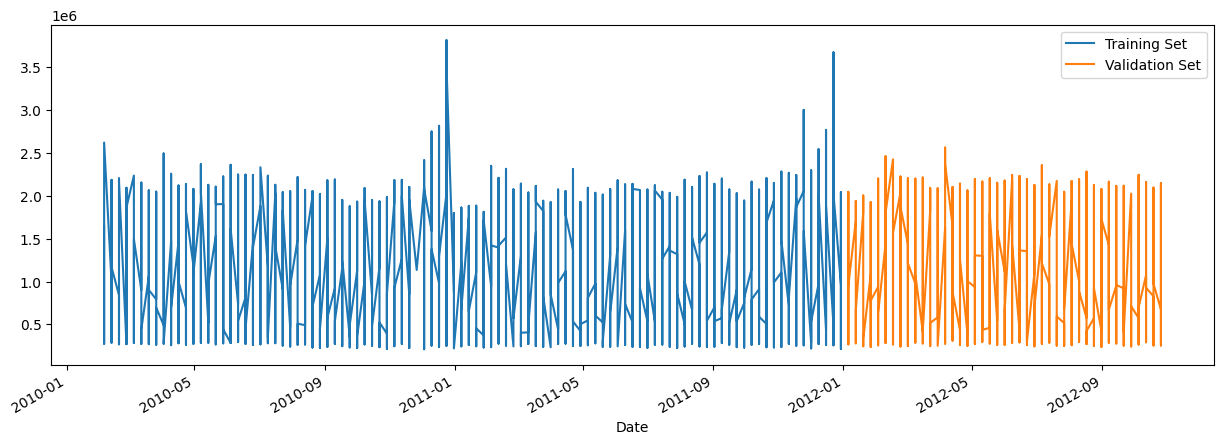

In [7]:
# 1. DATA PREPARATION

#The first thing we need to do is import and load the libraries that we will use in this exercise.

#pandas is a Python library specialized in handling and analyzing data structures. matplotlib is a Python library specialized in creating visualizations. seaborn is a Python library based on matplotlib, specialized in creating visualizations. git is a Python library that allows interaction with the GitHub version control system. xgboost is a Python library for implementing machine learning algorithms within the “Gradient Boosting” framework.

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')


df = pd.read_csv("/content/Walmart.csv")


# Transform "Temperature" column in Celsius
df['Temperature'] = (df['Temperature'] - 32) * (5/9)

# Display the first few rows to verify the transformation
print(df.head())

df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# 2. Exploratory Data Analysis (EDA)

# Calculate the interquartile range (IQR), which is the difference between the third quartile (Q3) and the first quartile (Q1) of the data table
Q1 = df['Weekly_Sales'].quantile(0.25)
Q3 = df['Weekly_Sales'].quantile(0.75)
IQR = Q3 - Q1

# Define limits to identify outliers
lower_threshold = Q1 - 1.5 * IQR
upper_threshold = Q3 + 1.5 * IQR

# Find and print the values that are outside the defined range
outliers = df[(df['Weekly_Sales'] < lower_threshold) | (df['Weekly_Sales'] > upper_threshold)]
print(outliers)

# It has been decided to modify only the record on the date “26-11-2010”. To do this, the value will be replaced by the average of the values recorded the day before and the day after.

# Select the date of the outlier value to be replaced
date = "26-11-2010"

# Get the row before and after the date to be modified
previous_row = df[df["Date"] < date].iloc[-1]
next_row = df[df["Date"] > date].iloc[0]

# Calculate the average and modify the value in the data table
average = (previous_row["Weekly_Sales"] + next_row["Weekly_Sales"]) / 2
df.loc[df["Date"] == date, "Weekly_Sales"] = average

# Plot the time series to check that the previous change was made correctly
df = df.sort_values(by='Date')

# Sort DataFrame
df.plot(figsize=(15,5), x='Date', y='Weekly_Sales', linestyle='-')


# 3. Training model

# create the temporary attributes corresponding to the data table
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
else:
    print("La columna 'Date' no existe en el DataFrame.")


def creacion_atributos(df):
  df['Day'] = df.index.dayofyear
  df['Quarter'] = df.index.quarter
  df['Month'] = df.index.month
  df['Year'] = df.index.year
  return df

# Call of function
df = creacion_atributos(df)

print(df)

# Create ranges for 'Temperature' and 'Fuel_Price'
# Using pd.cut to group data into defined intervals
df['Temperature_Range'] = pd.cut(df['Temperature'], bins=[-30, 0, 10, 20, 30, 40],
                                 labels=['<0°C', '0-10°C', '10-20°C', '20-30°C', '30-40°C'])
df['Fuel_Price_Range'] = pd.cut(df['Fuel_Price'], bins=[0, 2, 3, 4, 5],
                                labels=['$0-2', '$2-3', '$3-4', '$4-5'])

# Set up a 2x2 grid for the boxplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))


# Boxplot for 'Fuel_price'
sns.boxplot(data=df, x='Fuel_Price_Range', y='Weekly_Sales', ax=axes[0, 0], palette="Blues").set_title("Box Plot by Fuel_Price_Range")

# Boxplot for 'Month'
sns.boxplot(data=df, x='Month', y='Weekly_Sales', ax=axes[0, 1], palette="coolwarm").set_title("Box Plot by Month")

# Boxplot for 'Holiday_Flag'
sns.boxplot(data=df, x='Holiday_Flag', y='Weekly_Sales', ax=axes[1, 0], palette="Set2").set_title("Box Plot by Holiday Flag")

# Boxplot for 'Temperature_Range'
sns.boxplot(data=df, x='Temperature_Range', y='Weekly_Sales', ax=axes[1, 1], palette="Blues").set_title("Box Plot by Temperature Range")


# Adjust layout to prevent overlapping of titles and labels
plt.tight_layout()
plt.show()


# Split the data into training and test sets
train = df.loc[df.index < pd.to_datetime('2012-01-01')]
test = df.loc[df.index > pd.to_datetime('2012-01-01')]

# Plot both subsets
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, y='Weekly_Sales', label='Training Set ')
test.plot(ax=ax, y='Weekly_Sales', label='Validation Set')




<Axes: >

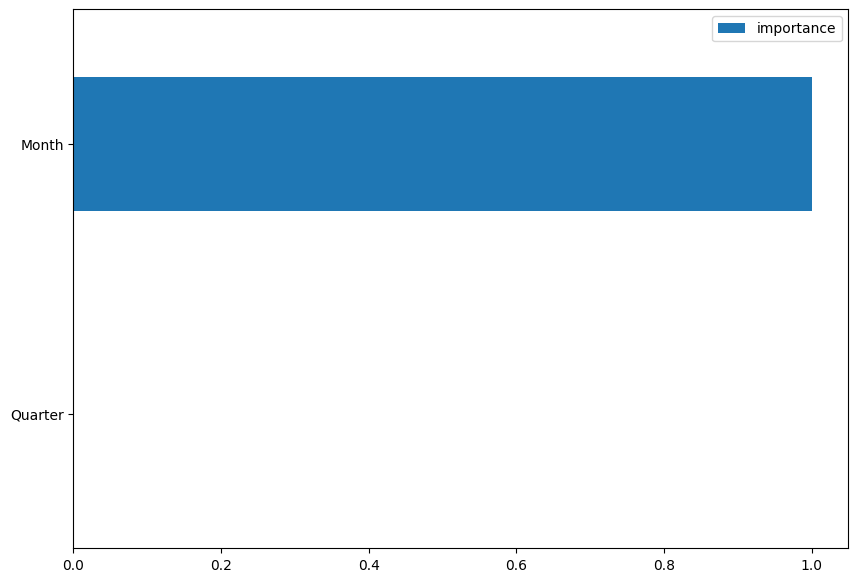

In [8]:
#divide the training and validation sets according to their attributes

atributes = ['Month', 'Quarter']
objetive = 'Weekly_Sales'

X_train = train[atributes]
y_train = train[objetive]

X_test = test[atributes]
y_test = test[objetive]

# Training of the model

reg = xgb.XGBRegressor(n_estimators=100,
                       early_stopping_rounds=100,
                       learning_rate= 0.3,
                       max_depth = 6,
                       min_child_wight = 1,
                       gamma = 0,
                       colsample_bytree = 1,
                       subsample = 1)
reg.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose=False)

# Weight of each parameter

fi = pd.DataFrame(data = reg.feature_importances_,
              index=reg.feature_names_in_,
                  columns=['importance'])
fig, ax = plt.subplots(figsize=(10, 7))
fi.sort_values('importance').plot(kind='barh', ax=ax)

In [9]:
# 4. Model Validation

# Predictions 2012
test['prediccion']= reg.predict(X_test)

# Merge info
df = df.merge(test[['prediccion']], how="left", left_index=True, right_index=True)


# (MAPE – Mean Absolute Percentage Error)
test["Porcentaje"] = (abs(test["prediccion"] - test["Weekly_Sales"]) / test["Weekly_Sales"]) * 100
test["Porcentaje"].mean()

63.583834177136914

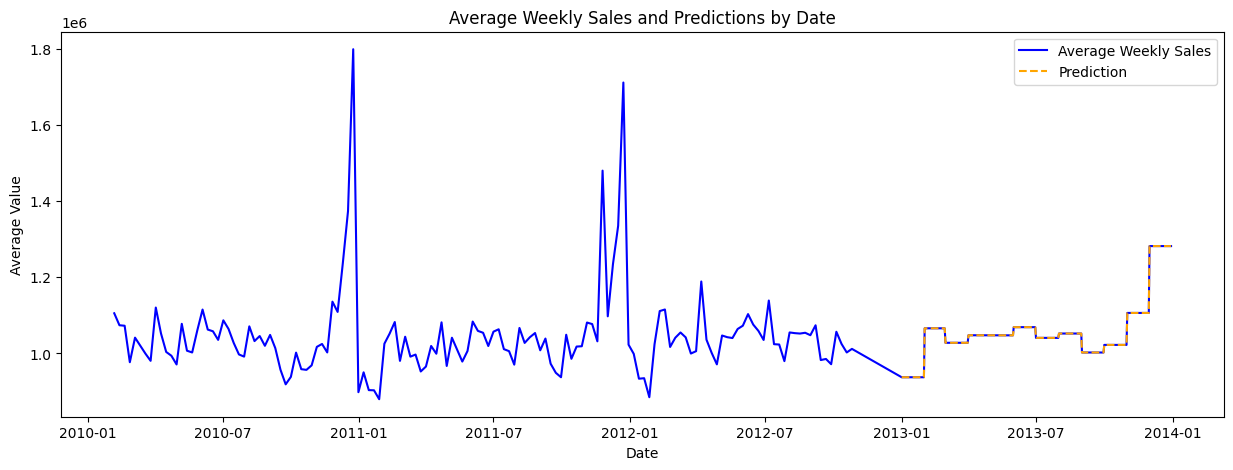

In [10]:
# 5. Forecasting Model

X_all = df[atributes]
y_all = df[objetive]

# Re-training of model
reg.fit(X_all, y_all, eval_set = [(X_all, y_all)], verbose=False)

#Dataset for predictions
future = pd.date_range('2013-01-01', '2013-12-30')
df_future = pd.DataFrame(index=future)

#Atributes creation
df_future = creacion_atributos(df_future)

#Merge info actual data + future
df_final = pd.concat([df, df_future])

# Generation of machine learning prediction
df_future['prediccion']= reg.predict(df_future[atributes])
df_final = df_final.merge(df_future[['prediccion']], how="left", left_index=True, right_index=True)


# Rename column and creation of final table
df_final = df_final.rename(columns={'prediccion_y': 'prediccion'})

df_final_weekly_sales = df[['Weekly_Sales']].rename(columns={'Weekly_Sales': 'value'})
df_final_predictions = df_future[['prediccion']].rename(columns={'prediccion': 'value'})

#Merge info
df_final = pd.concat([df_final_weekly_sales, df_final_predictions])
average_by_date = df_final.groupby(df_final.index).mean()

df_final

# Graph predictions
plt.figure(figsize=(15, 5))
plt.plot(average_by_date.index, average_by_date['value'], label='Average Weekly Sales', color='blue')
plt.plot(df_future.index, df_future['prediccion'], label='Prediction', color='orange', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Average Value')
plt.title('Average Weekly Sales and Predictions by Date')
plt.legend()
plt.show()




